# Mineração de Dados Massivos
## Analise de descrição de mercadorias de Notas Fiscais Eletrônicas

# Ambiente

## Bibliotecas

In [1]:
# Iniciando Ambiente
import numpy as np, pandas as pd, time, random
import datetime as dt

import nltk
from nltk.corpus import stopwords
import unicodedata

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pylab import rcParams
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

# Se necessário, descomente as linhas a seguir para ler as stopwords
nltk.download('stopwords')
nltk.download('rslp')
stemmer = nltk.stem.RSLPStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\svpon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\svpon\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


## Módulos

In [2]:
# Módulos de código de programação
#!pip install import-ipynb
import import_ipynb

# Carga de Arquivos
from carga import doCarga

# Tratamento de Dados         
from tratamento import doTratamento


importing Jupyter notebook from carga.ipynb
<class 'pandas.core.frame.DataFrame'>
Int64Index: 719921 entries, 0 to 879062
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Remetente      719921 non-null  object
 1   NovaDescricao  719921 non-null  object
 2   Categoria      719921 non-null  object
dtypes: object(3)
memory usage: 22.0+ MB
importing Jupyter notebook from tratamento.ipynb


## Variáveis de Ambiente

In [3]:
# Pasta aonde estão os dados
diretorio = '..\\dados\\'
#diretorio = "F:\\Weisner\\Documentos\\MEGA Estudos\\UNB - MDM - Mineração de Dados Massivos\\Artigo\\" 


In [4]:
# Contador de tempo
def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Duração: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

# Carga dos dados

## Abrir arquivo

In [5]:
# Carrega os dados
dfNotas = doCarga(diretorio, opcao=3)
print ("{} registros carregados".format(dfNotas.size))

2159763 registros carregados


## Processa se necessário

In [6]:
# doTratamento(dfNotas, diretorio)

In [7]:
# Amostra dos dados
dfNotas

,Remetente,NovaDescricao,Categoria
0,Fornecedor 001,CACHACA SAO FRANCISCO 12X970M,30.0simsim
1,Fornecedor 001,CACHACA YPIOCA EMP.OURO,30.0simsim
2,Fornecedor 001,CACHACA YPIOCA OURO,30.0simsim
3,Fornecedor 001,CACHACA YPIOCA PRATA,30.0simsim
4,Fornecedor 002,BB CACHACA SAGATIBA PURA (12) GF,30.0simsim
...,...,...,...
730469,Fornecedor 178,LED DISCO SUPIMPA BR 6500K 12W BIV,42.0nãonão
730470,Fornecedor 097,MARGARIDA PAPEL DOURADO METALIZADO,42.0nãonão
730471,Fornecedor 157,EXPOSITOR HUGY,42.0nãonão
879061,Fornecedor 014,LIMAO ESPREMIDO COCINERO,40.0simnão


In [8]:
# Remove a coluna de Remetente
dfNotas = dfNotas.drop(columns=['Remetente'])

# Balanceamento

## Situação - AS-IS

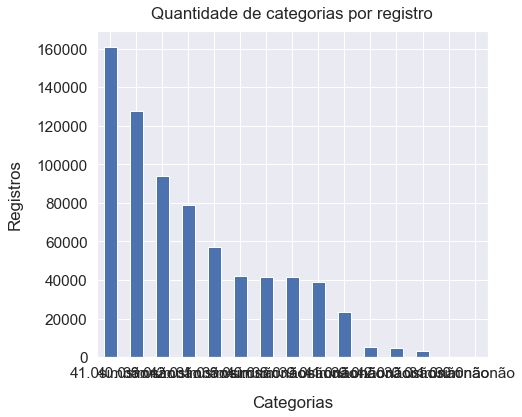

In [9]:
sns.set(font_scale=1.4)
dfNotas['Categoria'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Categorias", labelpad=14)
plt.ylabel("Registros", labelpad=14)
plt.title("Quantidade de categorias por registro", y=1.02);

plt.savefig('imagens/DisDesbalanceada.png', bbox_inches='tight');

In [10]:
dfNotas['Categoria'].value_counts()

41.0simnão    161005
40.0simnão    127642
38.0simnão     94179
42.0simnão     78789
31.0simsim     57000
38.0simsim     42003
40.0nãonão     41739
38.0nãonão     41409
39.0simnão     39237
41.0nãonão     23224
39.0nãonão      5457
42.0nãonão      4956
30.0simsim      3090
31.0nãonão       182
30.0nãonão         9
Name: Categoria, dtype: int64

In [11]:
# Separa os contadores
count_class_0, count_class_1, count_class_2, count_class_3, count_class_4, count_class_5, count_class_6, count_class_7, count_class_8, count_class_9, count_class_10, count_class_11, count_class_12, count_class_13, count_class_14 = dfNotas['Categoria'].value_counts()

In [12]:
# Divide datasets por classes
df_class_0 = dfNotas[dfNotas['Categoria'] == "41.0simnão"]
df_class_1 = dfNotas[dfNotas['Categoria'] == "40.0simnão"]
df_class_2 = dfNotas[dfNotas['Categoria'] == "38.0simnão"]
df_class_3 = dfNotas[dfNotas['Categoria'] == "42.0simnão"]
df_class_4 = dfNotas[dfNotas['Categoria'] == "31.0simsim"]
df_class_5 = dfNotas[dfNotas['Categoria'] == "38.0simsim"]
df_class_6 = dfNotas[dfNotas['Categoria'] == "40.0nãonão"]
df_class_7 = dfNotas[dfNotas['Categoria'] == "38.0nãonão"]
df_class_8 = dfNotas[dfNotas['Categoria'] == "39.0simnão"]
df_class_9 = dfNotas[dfNotas['Categoria'] == "41.0nãonão"]
df_class_10 = dfNotas[dfNotas['Categoria'] == "39.0nãonão"]
df_class_11 = dfNotas[dfNotas['Categoria'] == "42.0nãonão"]
df_class_12 = dfNotas[dfNotas['Categoria'] == "30.0simsim"] # Tamanho escolhido
df_class_13 = dfNotas[dfNotas['Categoria'] == "31.0nãonão"] # 182 - poucos registros
df_class_14 = dfNotas[dfNotas['Categoria'] == "30.0nãonão"] # 9 - insignificante

# Equipara os tamanhos 30.0simsim
# Foram equiparados ao tamanho da classe 3
#MaxSize = df_class_3.size 
#MaxSize = 3000 # df_class_3.size 
MaxSize = 2500 # df_class_3.size 

## Undersampling

In [13]:
# Faz o undersampling a partir de amostras aleatórias
df_class_0 = df_class_0.sample(MaxSize)
df_class_1 = df_class_1.sample(MaxSize)
df_class_2 = df_class_2.sample(MaxSize)
df_class_3 = df_class_3.sample(MaxSize)
df_class_4 = df_class_4.sample(MaxSize)
df_class_5 = df_class_5.sample(MaxSize)
df_class_6 = df_class_6.sample(MaxSize)
df_class_7 = df_class_7.sample(MaxSize)
df_class_8 = df_class_8.sample(MaxSize)
df_class_9 = df_class_9.sample(MaxSize)
df_class_10 = df_class_10.sample(MaxSize)
df_class_11 = df_class_11.sample(MaxSize)
df_class_12 = df_class_12.sample(MaxSize)

## Oversampling

In [14]:
# Random Oversampling
df_class_13 = df_class_13.sample(MaxSize, replace=True)

## Reagrupa

In [15]:
# Agrupa novamente
dfAjustado = pd.concat([df_class_0, df_class_1, df_class_2, df_class_3, df_class_4, df_class_5, df_class_6, df_class_7, df_class_8, df_class_9, df_class_10, df_class_11, df_class_12, df_class_13], axis=0)
dfAjustado = dfAjustado.sample(frac = 1)

In [16]:
dfAjustado

,NovaDescricao,Categoria
726519,CHAL.EL.PHILCO PHC20V 110V,42.0nãonão
267058,BISC CLUB SOCIAL RECH PROVOLONE,40.0simnão
1122,CACHACA ASA UMBURANA UAI,30.0simsim
657418,KIT GRAND CHEF MODELO N02 MAGO,39.0nãonão
638016,POPPER-FACA REFEICAO DOURADO C/10,38.0nãonão
...,...,...
727234,FERRO VAP.B&AMP;D AJ3032-BR 110V,42.0nãonão
161300,UMECTANTE OLEO COCO CD,38.0simsim
613762,TESTER TOMMY HILFIGER GIRL EDC,38.0nãonão
229422,LIMPA ALUMINIO ALUMIL LIQUIDO VIOLETA-UVA,39.0simnão


## Resultado - Dataset Balanceado

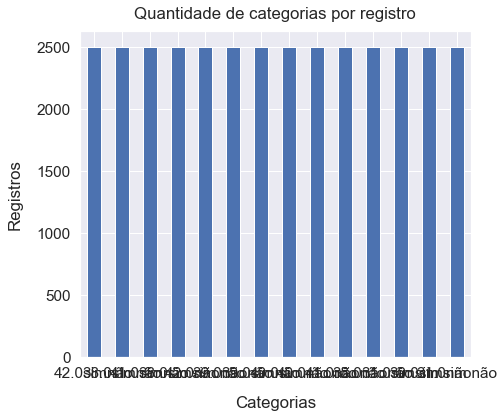

In [17]:
# Gera imagem do balanceamento ajustado
sns.set(font_scale=1.4)
dfAjustado['Categoria'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Categorias", labelpad=14)
plt.ylabel("Registros", labelpad=14)
plt.title("Quantidade de categorias por registro", y=1.02);
plt.savefig('imagens/DisBalanceada.png', bbox_inches='tight');  

In [18]:
dfAjustado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 726519 to 696168
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   NovaDescricao  35000 non-null  object
 1   Categoria      35000 non-null  object
dtypes: object(2)
memory usage: 820.3+ KB


In [19]:
dfAjustado = dfAjustado.sample(frac=1).reset_index(drop=True)
dfAjustado = dfAjustado[['Categoria', 'NovaDescricao']]

base_treino = dfAjustado.iloc[:20000,:]
base_teste = dfAjustado.iloc[20001:,:]

#exemplo_base_treino.Categoria.value_counts()
base_teste.shape

(14999, 2)

# Preleção

## StopWords

In [20]:
# Função para retirar as StopWords do Corpus
def removeStopWords(texto, lista_Stop):
    frases = []
    for (palavras, categoria) in texto:
        # List Comprehension para pegar palavras fora do lista_Stop
        semStop = [ p for p in palavras.split() if p not in lista_Stop]
        frases.append((semStop, categoria))
    return frases

In [21]:
# StopWords já contempladas na biblioteca NLTK
lista_Stop = nltk.corpus.stopwords.words('portuguese')
#np.transpose(lista_Stop)

In [22]:
# Adicionar StopWord customizada
#lista_Stop.append('Palavra_adicionar')

## Stemming

In [23]:
# Remover sufixos e prefixos das palavras
def aplica_Stemmer(texto):
    global nltk
    global lista_Stop
    nltk.download('rslp')
    stemmer = nltk.stem.RSLPStemmer()
    frases_sem_Stemming = []
    for ( Categoria, NovaDescricao) in texto:
        com_Stemming = [str(stemmer.stem(p)) for p in NovaDescricao.split() if p not in lista_Stop]
        frases_sem_Stemming.append((com_Stemming, Categoria))
    return frases_sem_Stemming

In [24]:
# Aplicat o Steeming na base de treino
frases_com_Stem_treinamento = aplica_Stemmer(base_treino.values)

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\svpon\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [25]:
pd.DataFrame(frases_com_Stem_treinamento, columns=['Produto', 'Categoria']).sample(10)

,Produto,Categoria
19486,"[ipu., prat, infantil, (2205)]",38.0nãonão
17882,"[cond, sed, so, ceram]",38.0simnão
19378,"[baralh, nip, grand]",31.0nãonão
13061,"[tamp, desc, ps, copobr]",38.0nãonão
690,"[ovo, confet]",40.0simnão
5379,"[chour, tradic, carn, vinh, prim]",31.0nãonão
10704,"[cerv, keep, cool, black, citru, c4mgg275, cod]",31.0nãonão
11569,"[cach, anisi, santiag, 600mlgf, cervej]",30.0simsim
2691,"[ml-, rapar, quint, colheit, selecion, bco.]",31.0simsim
10760,"[sac, plast.trans.40x60cm, jbm]",39.0nãonão


In [26]:
# Aplica o Steaming na base de testes
frases_com_Stem_teste = aplica_Stemmer(base_teste.values)

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\svpon\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


# Análise dos dados de entrada

In [27]:
# Função para retornar apenas as palavras, sem a classificação (categoria)
def busca_Palavras(frases):
    todas_Palavras = []
    for (palavras, Categoria) in frases:
        todas_Palavras.extend(palavras)
    return todas_Palavras

In [28]:
# Função para verificar a quantidade de vezes que a palavra é mencionada
def busca_frequencia(palavras):
    global nltk
    palavras = nltk.FreqDist(palavras)
    return palavras

In [29]:
palavras_treinamento = busca_Palavras(frases_com_Stem_treinamento)
palavras_teste = busca_Palavras(frases_com_Stem_teste)

In [30]:
print ('Quantidade de palavras no treinamento {}'.format(pd.DataFrame(palavras_treinamento).count()))

Quantidade de palavras no treinamento 0    94179
dtype: int64


In [31]:
frequencia_treinamento = busca_frequencia(palavras_treinamento)

In [32]:
# Função para retornar somente as palavras únicas
def busca_palavras_unicas(frequencia):
    freq = frequencia.keys()
    return freq

In [33]:
# Função para identificar quais palavras únicas estão no documento passo para função
def extrator_palavras(documento):
    global palavras_unicas_treinamento
    doc = set(documento)
    caracteristicas = {}
    for palavras in palavras_unicas_treinamento:
        caracteristicas['%s' % palavras] = (palavras in doc)
    return caracteristicas

In [34]:
# Mesmo anterior, só que dedicada para teste
def extrator_palavras_teste(documento):
    global palavras_unicas_teste
    doc = set(documento)
    caracteristicas = {}
    for palavras in palavras_unicas_teste:
        caracteristicas['%s' % palavras] = (palavras in doc)
    return caracteristicas

In [35]:
# Visualizar quais palavras ocorrem com maior frequência
# Pode ajudar a tunnar a stopwords
frequencia_treinamento.most_common(20)

[('cachac', 674),
 ('cab', 477),
 ('sac', 452),
 ('beb', 352),
 ('fit', 345),
 ('220v', 319),
 ('mdf', 309),
 ('cop', 301),
 ('lix', 301),
 ('kit', 299),
 ('dec', 290),
 ('conf', 289),
 ('esm', 282),
 ('disc', 275),
 ('aguard', 274),
 ('gf', 268),
 ('lt', 257),
 ('col', 252),
 ('plast', 246),
 ('tto', 233)]

In [36]:
# Ajustando treinamento
frequencia_teste = busca_frequencia(palavras_teste)

palavras_unicas_treinamento = busca_palavras_unicas(frequencia_treinamento)
palavras_unicas_teste = busca_palavras_unicas(frequencia_teste)

In [37]:
# Faz o preenchimento se tem ou não a característica de acordo com parâmetro
base_completa_treinamento = nltk.classify.apply_features(extrator_palavras, frases_com_Stem_treinamento)
base_completa_teste = nltk.classify.apply_features(extrator_palavras_teste, frases_com_Stem_teste)

In [38]:
# ConditionalExponentialClassifier
tic()
Acuracia_CEC = 0
CEC_Clalssifier = nltk.ConditionalExponentialClassifier.train(base_completa_treinamento)

  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -2.63906        0.071


C:\ProgramData\Anaconda3\lib\site-packages\nltk\classify\maxent.py:1386: RuntimeWarning: overflow encountered in power
  exp_nf_delta = 2 ** nf_delta
C:\ProgramData\Anaconda3\lib\site-packages\nltk\classify\maxent.py:1388: RuntimeWarning: invalid value encountered in multiply
  sum1 = numpy.sum(exp_nf_delta * A, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\nltk\classify\maxent.py:1389: RuntimeWarning: invalid value encountered in multiply
  sum2 = numpy.sum(nf_exp_nf_delta * A, axis=0)


         Final               nan        0.072


In [39]:
Acuracia_CEC = nltk.classify.accuracy(CEC_Clalssifier, base_completa_teste)
tac()

Duração: 12hour:49min:59sec


In [40]:
Acuracia_CEC

0.07107140476031736